In [165]:
import cv2
import numpy as np
import time
import os
from pathlib import Path
#from picamera2 import Picamera2
from matplotlib import pyplot as plt

In [166]:
# === Reference reflectances (Table 3 from NDVIpi paper) ===
# Order: White, Sand, Brown, Indian Birch, Forest Green, Burgundy
RED_REFLECTANCES = np.array([92.69, 63.59, 16.29, 66.72, 4.90, 25.53])
NIR_REFLECTANCES = np.array([87.62, 60.85, 16.13, 62.69, 5.88, 39.40])

# === Parameters ===
CAPTURE_SIZE = (2592, 1952)
ROTATION = 180
NIR_LEAK_FRACTION = 0.10     # NIR “leak” correction fraction
CALIB_POLY_DEGREE = 2        # 2nd-order calibration polynomial
SAVE_DIR = Path("./ndvipi_output")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

In [167]:
# Cell 2: dual-camera capture
def capture_dual_images(rotation=ROTATION, size=CAPTURE_SIZE, delay=0.5):
    picam_rgb = Picamera2(0)
    picam_nir = Picamera2(1)

    config_rgb = picam_rgb.create_still_configuration(main={"size": size})
    config_nir = picam_nir.create_still_configuration(main={"size": size})
    picam_rgb.configure(config_rgb)
    picam_nir.configure(config_nir)

    picam_rgb.start()
    picam_nir.start()
    time.sleep(delay)  # let autoexposure stabilize

    rgb_frame = picam_rgb.capture_array("main")
    nir_frame = picam_nir.capture_array("main")

    picam_rgb.stop()
    picam_nir.stop()

    rgb_img = cv2.cvtColor(rgb_frame, cv2.COLOR_RGB2BGR)
    noir_img = cv2.cvtColor(nir_frame, cv2.COLOR_RGB2BGR)

    if rotation:
        M = cv2.getRotationMatrix2D((size[0]//2, size[1]//2), rotation, 1.0)
        rgb_img = cv2.warpAffine(rgb_img, M, size)
        noir_img = cv2.warpAffine(noir_img, M, size)

    print("Captured RGB and NoIR images successfully.")
    return rgb_img, noir_img


In [168]:
# Cell 3: visualization and save utilities
def show_image(img, title="Image", cmap=None, figsize=(10,8)):
    plt.figure(figsize=figsize)
    if img.ndim == 3 and img.shape[2] == 3:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis("off")
    plt.show()

def save_16bit_png(arr_float_01, filename):
    arr = np.clip(arr_float_01, -1, 1)
    arr = (arr + 1) / 2  # -1..1 → 0..1
    arr16 = (arr * 65535).astype(np.uint16)
    path = SAVE_DIR / filename
    cv2.imwrite(str(path), arr16)
    print(f"Saved 16-bit NDVI image: {path}")


In [169]:
# Cell 4: calibration patch sampling
def sample_patches_mean(channel_img, patch_bboxes):
    means = []
    for (x, y, w, h) in patch_bboxes:
        
        # --- FIX: Check dimensions to avoid ValueError ---
        if channel_img.ndim == 3:
            y_max, x_max, _ = channel_img.shape
        else: # For a 2D array (the single channel slice)
            y_max, x_max = channel_img.shape
        # ------------------------------------------------
            
        # Ensure ROI coordinates are within bounds
        x = np.clip(x, 0, x_max - w)
        y = np.clip(y, 0, y_max - h)
        
        roi = channel_img[y:y+h, x:x+w]
        
        if roi.size > 0:
             means.append(float(np.mean(roi)))
        else:
             means.append(np.nan) 
             
    return np.array(means, dtype=float)


In [170]:
# Cell 5: calibration fitting
def fit_calibration(dn_means, reflectances, degree=2):
    coeffs = np.polyfit(dn_means, reflectances, degree)
    return np.poly1d(coeffs)

def apply_calibration(poly, channel_image):
    refl = poly(channel_image.astype(float))
    return np.clip(refl, 0.0, 100.0)


In [171]:
# Cell 6: image alignment
def align_images(base_gray, moving_gray, max_features=5000, good_match_percent=0.15):
    orb = cv2.ORB_create(max_features)
    keypoints1, descriptors1 = orb.detectAndCompute(base_gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(moving_gray, None)

    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)
    matches = sorted(matches, key=lambda x: x.distance)
    num_good = int(len(matches) * good_match_percent)
    matches = matches[:num_good]

    pts1 = np.float32([keypoints1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([keypoints2[m.trainIdx].pt for m in matches])
    h, _ = cv2.findHomography(pts2, pts1, cv2.RANSAC)
    height, width = base_gray.shape
    aligned = cv2.warpPerspective(moving_gray, h, (width, height))
    return aligned, h


In [172]:
# Cell 7: full NDVI computation
def compute_calibrated_ndvi(rgb_img, noir_img, patch_bboxes, leak_fraction=NIR_LEAK_FRACTION):
    # Sample mean DN from calibration patches
    red_dn = sample_patches_mean(rgb_img[:,:,2], patch_bboxes)
    nir_dn = sample_patches_mean(noir_img[:,:,0], patch_bboxes)  # blue channel = NIR

    print("Red DN means:", red_dn)
    print("NIR DN means:", nir_dn)

    # Fit calibration curves
    poly_red = fit_calibration(red_dn, RED_REFLECTANCES, CALIB_POLY_DEGREE)
    poly_nir = fit_calibration(nir_dn, NIR_REFLECTANCES, CALIB_POLY_DEGREE)

    # Convert to reflectance images
    red_refl = apply_calibration(poly_red, rgb_img[:,:,2])
    nir_refl_raw = apply_calibration(poly_nir, noir_img[:,:,0])

    # Apply NIR leak correction
    nir_refl = np.clip(nir_refl_raw - leak_fraction * red_refl, 0, 100)

    # Align NoIR to RGB
    base_gray = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2GRAY)
    moving_gray = cv2.cvtColor(noir_img, cv2.COLOR_BGR2GRAY)
    _, H = align_images(base_gray, moving_gray)
    height, width = base_gray.shape
    nir_refl_aligned = cv2.warpPerspective(nir_refl, H, (width, height))

    # Compute NDVI
    red_frac = red_refl / 100.0
    nir_frac = nir_refl_aligned / 100.0
    denom = nir_frac + red_frac
    denom[denom == 0] = 1e-6
    ndvi = (nir_frac - red_frac) / denom
    ndvi = np.clip(ndvi, -1, 1)

    # Save results
    save_16bit_png(ndvi, "ndvi_16bit.png")
    return ndvi


In [173]:
# Cell 8: NDVI colorization
def colorize_ndvi(ndvi, cmap_name='RdYlGn'):
    cmap = plt.get_cmap(cmap_name)
    norm = (ndvi + 1) / 2
    color_img = (cmap(norm)[:,:,:3] * 255).astype(np.uint8)
    return cv2.cvtColor(color_img, cv2.COLOR_RGB2BGR)

Red DN means: [70.011875 64.029375 64.029375 64.029375 64.029375 64.029375]
NIR DN means: [17.604375 16.663125 16.663125 16.663125 16.663125 16.663125]
Saved 16-bit NDVI image: ndvipi_output/ndvi_16bit.png


/var/folders/lg/d7pgjbkd6nz7d5lzmtwv_ltr0000gn/T/ipykernel_72516/498424200.py:3: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(dn_means, reflectances, degree)
/var/folders/lg/d7pgjbkd6nz7d5lzmtwv_ltr0000gn/T/ipykernel_72516/498424200.py:3: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(dn_means, reflectances, degree)


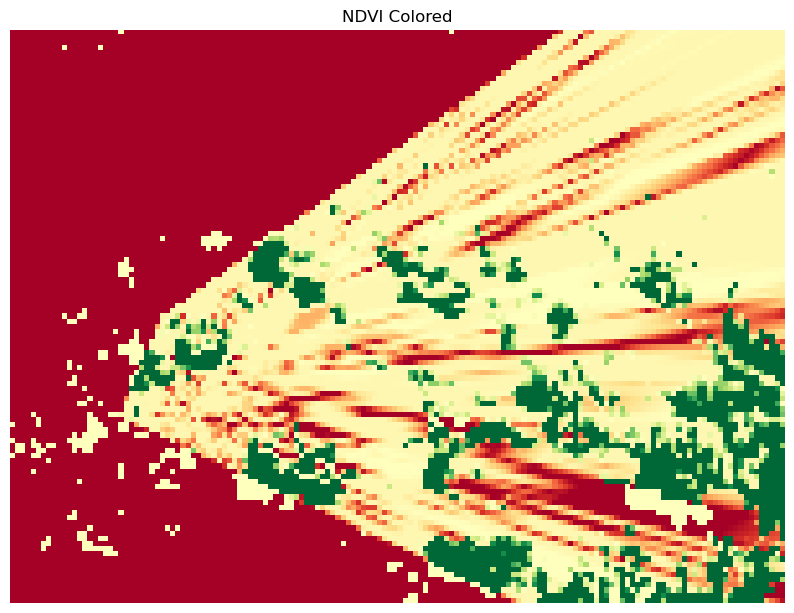

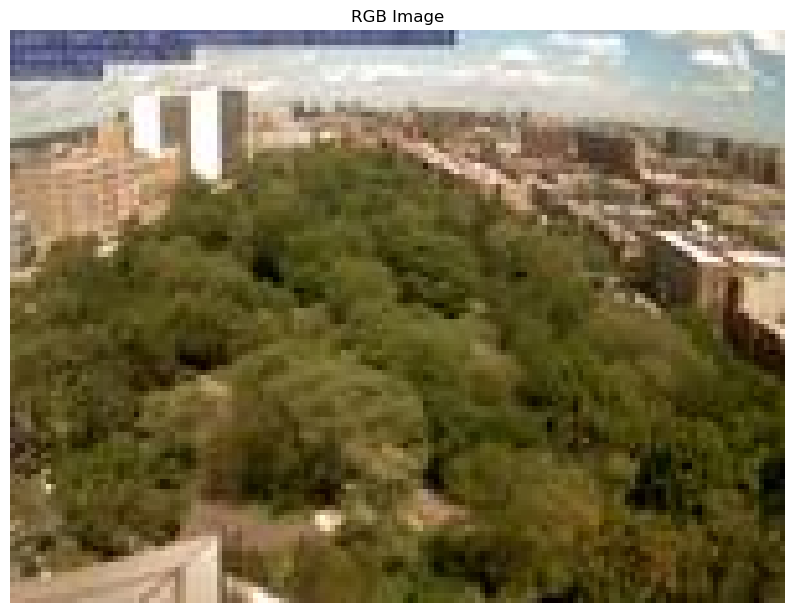

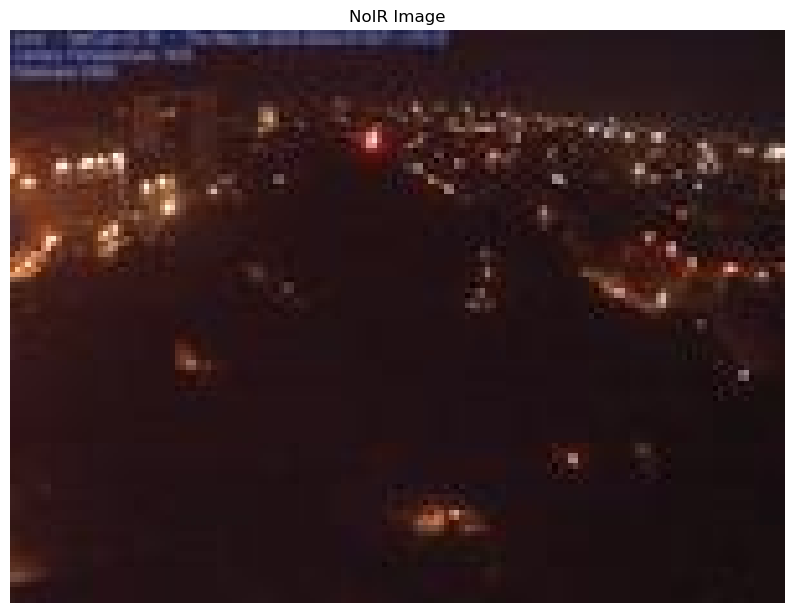

In [174]:
# 1. Capture both images
#rgb_img, noir_img = capture_dual_images()
rgb_img = cv2.imread("rgb_image.jpg")
noir_img = cv2.imread("noir_image.jpg")

# 2. Calibration patch coordinates from the article
patch_bboxes = [
    (100,100,40,40), (200,100,40,40), (300,100,40,40),
    (400,100,40,40), (500,100,40,40), (600,100,40,40)
]

# 3. Compute calibrated NDVI
ndvi = compute_calibrated_ndvi(rgb_img, noir_img, patch_bboxes)

# 4. Display colored NDVI
ndvi_colored = colorize_ndvi(ndvi)
show_image(ndvi_colored, "NDVI Colored")
show_image(rgb_img, "RGB Image")
show_image(noir_img, "NoIR Image")
